In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
%%time

fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = 2016
cat = 2
if year == 2016:
    path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_8_0_21/src/cms_lpc_llp/llp_ntupler/'
    file_name = 'displacedJetMuon_ntupler_RunIISummer16'
else:
    path = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_7/src/cms_lpc_llp/llp_ntupler/'
    file_name = 'displacedJetMuon_ntupler_RunIIFall17'

fpath_bkg['bbbb10m'] = path + file_name+ '_v8.root'



# fpath_bkg['bbbb0.1m'] = sig_path + 'WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-100_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'

if year == 2016:lumi = 35.92*1000 #in pb-1
elif year == 2017:lumi = 41.53 * 1000
else: lumi = 59.74 * 1000
    

NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 

    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     tree[k] = root_dir['ntuples']
    a = tree_bkg[k]["gLLP_csc"].array()
    print(len(a))

bbbb10m /storage/user/christiw/login-1/christiw/LLP/CMSSW_8_0_21/src/cms_lpc_llp/llp_ntupler/displacedJetMuon_ntupler_RunIISummer16_v8.root
203427
CPU times: user 19.8 s, sys: 4.39 s, total: 24.2 s
Wall time: 19.7 s


# legend

In [3]:

pdgId = 13

trigger_names_file = '/nfshome/christiw/llp/delayed_jet_analyzer/data/trigger_names_llp_v1.dat'
trigger_names = []
with open(trigger_names_file) as f:
    reader = csv.reader(f, delimiter=" ")
    for line in reader:
        trigger_names.append(line[2])

trigger_paths = [177,362,87,135] #PFMET120


# 177 HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
# 362 HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ
# 310 HLT_PFMET120_PFMHT120_IDTight
# 87 HLT_Ele32_WPTight_Gsf
# 135 HLT_IsoMu24
# 310 PFMET
# xsec = {}
# xsec['bbbb10m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb1m'] = (5.328E-01 + 8.4E-01) *0.324
# xsec['bbbb0.1m'] = (5.328E-01 + 8.4E-01) *0.324


# xsec['WJetsToLNu'] = 61526.7


legend = {}
legend['bbbb10m'] = 'signal c#tau = 10 m'
legend['bbbb1m'] = 'signal c#tau = 1 m'
legend['bbbb0.1m'] = 'signal c#tau = 0.1 m'

legend['DYJetsToLL'] = 'DYJetsToLL'
legend['WJetsToLNu'] = 'WJetsToLNu'

# Helper Functions

In [4]:
import math
def deltaPhi( phi1,  phi2):

    dphi = phi1-phi2
    while (dphi > math.pi):
        dphi -= 2*math.pi
  
    while (dphi <= -math.pi):
        dphi += 2*math.pi
    return dphi
def deltaR(eta1, phi1, eta2, phi2):
    dphi = deltaPhi(phi1,phi2)
    deta = eta1 - eta2
    return (dphi*dphi + deta*deta)**0.5

# Load variables

In [3]:
%%time

JET_PT_CUT = 10
MUON_PT_CUT = 20
gLLP_csc = {}

cscSegClusterSize = {}
cscSegClusterTime = {}

cscRechitClusterSize = {}
cscRechitClusterTime = {}

nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto = {}
nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto = {}

selections_segcluster = {}
selections_rechitcluster = {}
keys = ['sig','bkg']
T = tree_bkg['bbbb10m']
for k in keys:
    ########### SELECTION: CLUSTERS ############

    sel_segcluster = T.array('cscSegClusterMaxStationRatio') > 0.1
    sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterJetVetoPt') < JET_PT_CUT)
    sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterMuonVetoPt') < MUON_PT_CUT)
#     sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterMe11Ratio') < 0.001)
#     sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterMe12Ratio') < 0.001)
    sel_segcluster = np.logical_and(sel_segcluster, np.abs(T.array('cscSegClusterMaxChamber')) > 12)
    if k == 'bkg':
        sel_segcluster = np.logical_and(sel_segcluster, np.logical_not(np.abs(T.array('cscSegCluster_match_gParticle_id')) == 9000006))



    sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterTime') < 22)
    sel_segcluster = np.logical_and( sel_segcluster, T.array('cscSegClusterTime') > -12.5)

    selections_segcluster['oot-2'] = np.logical_and(sel_segcluster, T.array('cscSegClusterTime') < -28)
    selections_segcluster['oot-2'] = np.logical_and(selections_segcluster['oot-2'], T.array('cscSegClusterTime') > -62.5)
    
    selections_segcluster['oot-1'] = np.logical_and(sel_segcluster, T.array('cscSegClusterTime') < -12.5)
    selections_segcluster['oot-1'] = np.logical_and(selections_segcluster['oot-1'], T.array('cscSegClusterTime') > -37.5)
    
    selections_segcluster['signal'] = np.logical_and( sel_segcluster, T.array('cscSegClusterTime') < 22)
    selections_segcluster['signal'] = np.logical_and( selections_segcluster['signal'], T.array('cscSegClusterTime') > -12.5)
    
    selections_segcluster['oot1'] = np.logical_and( sel_segcluster, T.array('cscSegClusterTime') < 47)
    selections_segcluster['oot1'] = np.logical_and( selections_segcluster['oot1'], T.array('cscSegClusterTime') > 12.5)

    selections_segcluster['oot2'] = np.logical_and(sel_segcluster, T.array('cscSegClusterTime') < 72)
    selections_segcluster['oot2'] = np.logical_and(selections_segcluster['oot2'], T.array('cscSegClusterTime') > 37.5)
    
    selections_segcluster['oot3'] = np.logical_and(sel_segcluster, T.array('cscSegClusterTime') < 97)
    selections_segcluster['oot3'] = np.logical_and(selections_segcluster['oot3'], T.array('cscSegClusterTime') > 62.5)
    
    sel_rechitcluster = T.array('cscRechitClusterMaxStationRatio') > 0.1
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterJetVetoPt') < JET_PT_CUT)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMuonVetoPt') < MUON_PT_CUT)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe11Ratio') < 0.01)
#     sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterMe12Ratio') < 0.01)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.abs(T.array('cscRechitClusterMaxChamber')) > 12)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') < 22)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') > -12.5)
    if k == 'bkg':
        sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_not(np.abs(T.array('cscRechitCluster_match_gParticle_id')) == 9000006))
    
    selections_rechitcluster['oot-2'] = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterTime') < -28)
    selections_rechitcluster['oot-2'] = np.logical_and(selections_rechitcluster['oot-2'], T.array('cscRechitClusterTime') > -62.5)
    
    selections_rechitcluster['oot-1'] = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterTime') < -12.5)
    selections_rechitcluster['oot-1'] = np.logical_and(selections_rechitcluster['oot-1'], T.array('cscRechitClusterTime') > -37.5)
    
    selections_rechitcluster['signal'] = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') < 22)
    selections_rechitcluster['signal'] = np.logical_and( selections_rechitcluster['signal'], T.array('cscRechitClusterTime') > -12.5)
    
    selections_rechitcluster['oot1'] = np.logical_and( sel_rechitcluster, T.array('cscRechitClusterTime') < 47)
    selections_rechitcluster['oot1'] = np.logical_and( selections_rechitcluster['oot1'], T.array('cscRechitClusterTime') > 12.5)

    selections_rechitcluster['oot2'] = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterTime') < 72)
    selections_rechitcluster['oot2'] = np.logical_and(selections_rechitcluster['oot2'], T.array('cscRechitClusterTime') > 37.5)
    
    selections_rechitcluster['oot3'] = np.logical_and(sel_rechitcluster, T.array('cscRechitClusterTime') < 97)
    selections_rechitcluster['oot3'] = np.logical_and(selections_rechitcluster['oot3'], T.array('cscRechitClusterTime') > 62.5)

########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    # select only triggered events
    sel_ev= np.ones(hlt[:,0].shape, dtype=bool)
#     sel_ev= np.zeros(hlt[:,0].shape)
#     for tr in trigger_paths:
#         sel_ev  = np.logical_or(sel_ev,hlt[:,tr])
#     print(np.count_nonzero(sel_ev))
    if k == 'sig':
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) >= 1)
        print(np.count_nonzero(sel_ev))
        print("rechits")
        for kk, v in selections_rechitcluster.items():
            print(kk, np.count_nonzero(np.logical_and(sel_ev, (v.sum()) >= 1)))
        print("segments")
        for kk, v in selections_segcluster.items():
            print(kk, np.count_nonzero(np.logical_and(sel_ev, (v.sum()) >= 1)))
    else:
        sel_ev = np.logical_and(sel_ev, np.sum(T.array('gLLP_csc'),axis = 1) == 0)
        decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
        decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
        cond1 = np.logical_and(decay_distance0 < 200, decay_distance1 < 200)
        cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
        sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))


    sel_segev = np.logical_and(sel_ev, (sel_segcluster.sum()) >= 1)
    sel_rechitev = np.logical_and(sel_ev, (sel_rechitcluster.sum()) >= 1)


    
    cscSegClusterSize[k] = T.array('cscSegClusterSize')[sel_segcluster][sel_ev]
    cscSegClusterTime[k] = T.array('cscSegClusterTime')[sel_segcluster][sel_ev]
    
    cscRechitClusterSize[k] = T.array('cscRechitClusterSize')[sel_rechitcluster][sel_ev]
    cscRechitClusterTime[k] = T.array('cscRechitClusterTime')[sel_rechitcluster][sel_ev]
    
    nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k] = cscRechitClusterSize[k].sum()
    nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k] = cscSegClusterSize[k].sum()
    
    print(len(nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k]),len(nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k]))

33567
rechits
oot-2 0
oot-1 0
signal 12324
oot1 3274
oot2 0
oot3 0
segments
oot-2 0
oot-1 0
signal 11389
oot1 2287
oot2 0
oot3 0
33567 33567
148537 148537
CPU times: user 1min 46s, sys: 2.84 s, total: 1min 48s
Wall time: 1min 45s


# 1D histogram

33567
148537
0.12378311157226562


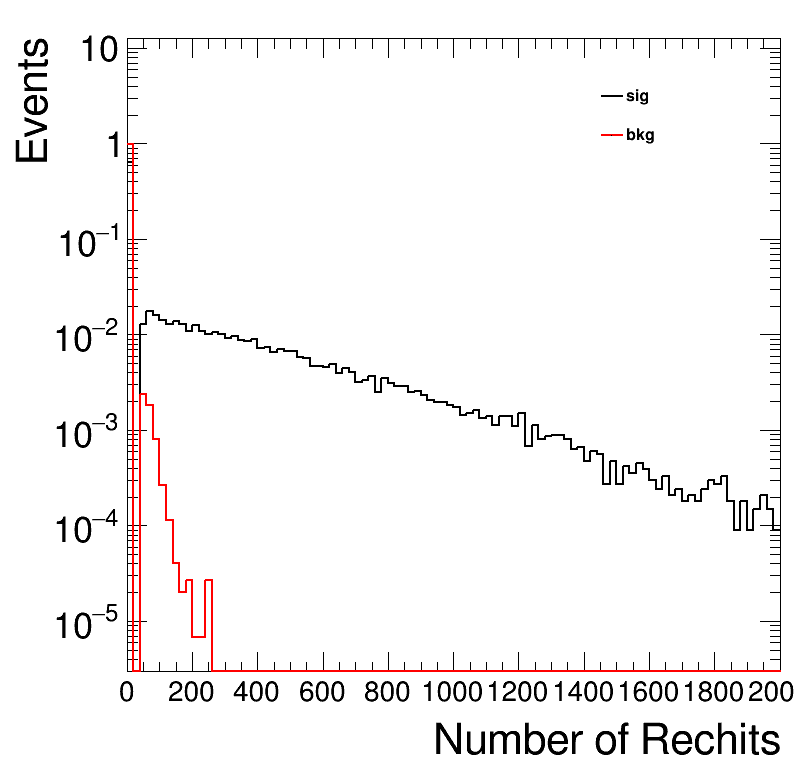

In [4]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0

for i, k in enumerate(keys):

    bins = [100,-100,150]
#     h[k] = create_TH1D( cscRechitClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    bins = [100,0,2000]
#     if k == 'sig': continue
    h[k] = create_TH1D( nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['Number of Rechits', 'Events'], name=k, binning=bins)
#     h[k] = create_TH1D( nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['Number of Segments', 'Events'], name=k, binning=[80,0,300])

    print(len(nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten()))

#     h[k] = create_TH1D( cscSegClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    h[k].SetLineColor(std_color_list[i])


    leg.AddEntry(h[k], k)
    h[k].SetMinimum(0.1)
    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 20)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
#     h['seg'].DrawNormalized('same hist')




#     h[k].GetXaxis()


leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# compare different bunch crossing

2.448399066925049


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


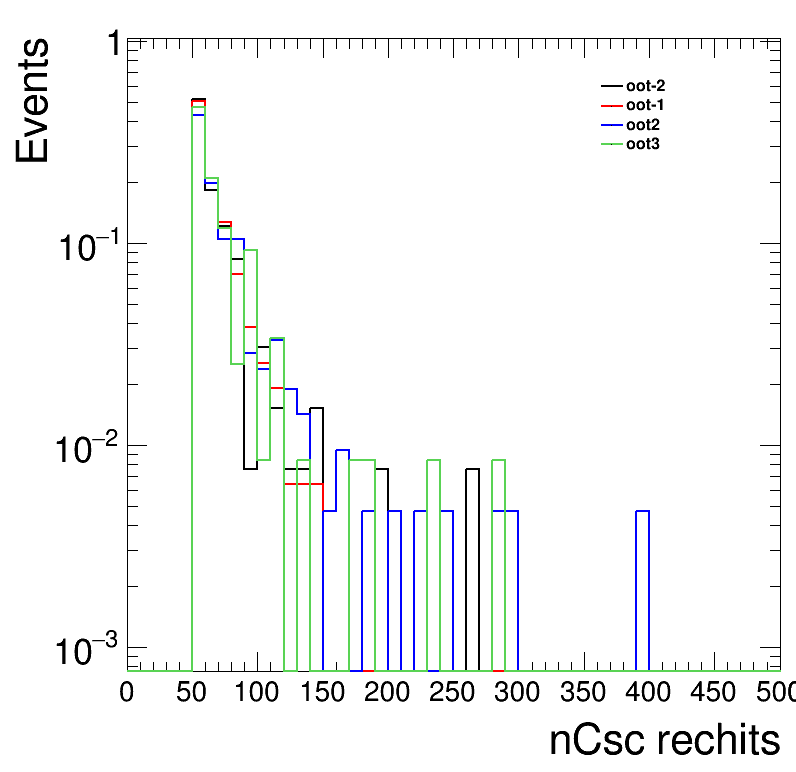

In [42]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 800, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.75,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)
maximum = 0
i = 0
for k, v in selections_rechitcluster.items():
    if k == 'signal' or k == 'oot1': continue
    sel_ev = np.sum(T.array('gLLP_csc'),axis = 1) == 0
    decay_distance0 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,0]**2 + T.array('gLLP_decay_vertex_y')[:,0]**2 + T.array('gLLP_decay_vertex_z')[:,0]**2)
    decay_distance1 = np.sqrt(T.array('gLLP_decay_vertex_x')[:,1]**2 + T.array('gLLP_decay_vertex_y')[:,1]**2 + T.array('gLLP_decay_vertex_z')[:,1]**2)
    cond1 = np.logical_and(decay_distance0 < 100, decay_distance1 < 100)
    cond2 = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z')[:,0]) > 1200, np.abs(T.array('gLLP_decay_vertex_z')[:,1]) > 1200)
    sel_ev = np.logical_and(sel_ev, np.logical_or(cond1, cond2))
    sel_ev = np.logical_and(sel_ev, (v.sum()) >= 1)
#     cscRechitClusterSize[k] = T.array('cscSegClusterSize')[v][sel_ev]


    cscRechitClusterSize[k] = T.array('cscRechitClusterSize')[v][sel_ev]
    bins = [100,-100,150]
#     print(cscRechitClusterTime[k].flatten())
#     h[k] = create_TH1D( cscRechitClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    bins = [50,0,500]
    if k == 'sig': continue
    h[k] = create_TH1D( cscRechitClusterSize[k].sum(), axis_title=['nCsc rechits', 'Events'], name=k, binning=bins)
#     h[k] = create_TH1D( nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto[k].flatten(), axis_title=['nCsc rechits', 'Events'], name=k, binning=bins)



#     h[k] = create_TH1D( cscSegClusterTime[k].flatten(), axis_title=['rechit cluster time [ns]', 'Events'], name=k, binning=bins)
    h[k].SetLineColor(std_color_list[i])


    leg.AddEntry(h[k], k)
    h[k].SetMinimum(0.1)
    maximum = max(maximum, h[k].GetMaximum() )
    h[k].SetMaximum(maximum * 2)
    h[k].GetXaxis().SetLabelSize(0.04)
    h[k].DrawNormalized('same hist')
#     h['seg'].DrawNormalized('same hist')

    i += 1


#     h[k].GetXaxis()


leg.Draw()


# if setlog: 
c.SetLogy()
c.Draw()
print(time.time()-start_t)

# ROC Curve

(180,) (180,)
sig RecHits 5121.9655172413795
129
(74,) (74,)
sig Segments 843.9602272727273
14


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


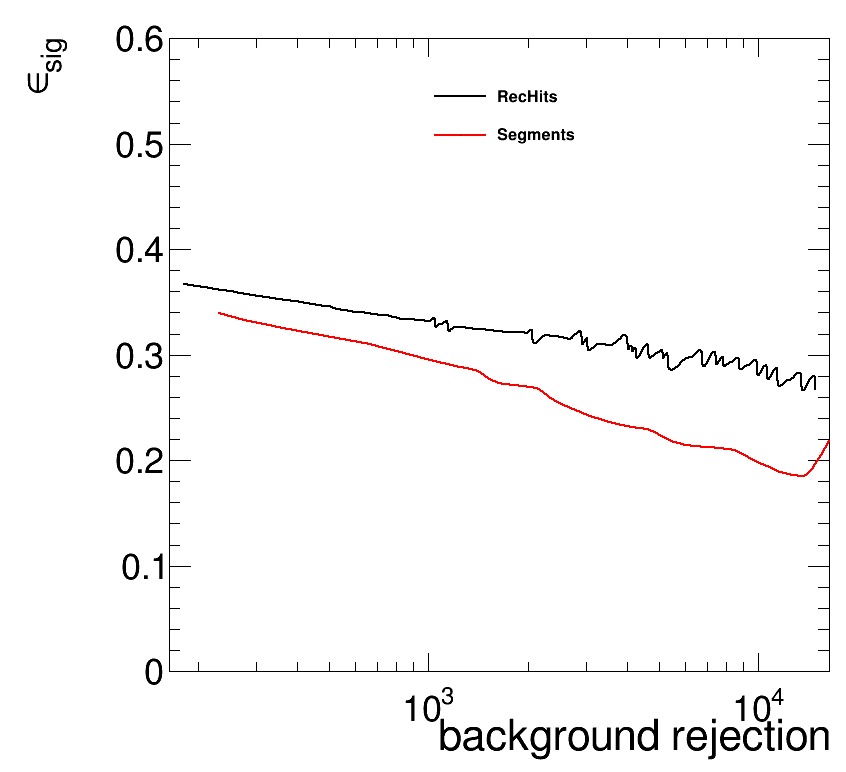

In [5]:
#ROC curve
c = rt.TCanvas('c','c', 850, 800)
leg = rt.TLegend(0.5,0.80,0.85,0.90)
# leg = rt.TLegend(0.3,0.80,0.55,0.90)


leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
gr = {}

var = [nCscRechitCluster_JetMuonVetoCluster0p4_Me1112Veto, nCscSegCluster_JetMuonVetoCluster0p4_Me1112Veto,]
name =['RecHits', 'Segments', ]
label = ['RecHits', 'Segments',]

qcd_key = 'DYJetsToLL'
thre = np.array(range(20))*10
for i in range(len(var)):
    if i == 0:
        thre = np.array(range(180))
    else:
        thre = np.array(range(200))
    eff = {}
    for k in var[i].keys():
        eff[k] = []
        for th in thre:
            eff[k].append(1.0*np.count_nonzero(var[i][k].flatten()>th)/len(var[i][k].flatten()))
        eff[k] = np.array(eff[k])
    #Plotting ROC curve
    eff['sig'] = eff['sig'][np.logical_not(eff['bkg'] <= 0)]
    eff['bkg'] = eff['bkg'][np.logical_not(eff['bkg'] <= 0)]
    print(eff['bkg'].shape, eff['sig'].shape)
    #         gr[name[i]+sig_k] = create_TGraph(eff[sig_k],eff[qcd_key],axis_title = ['#epsilon_{sig}','background efficiency'])


    gr[name[i]] = create_TGraph(np.reciprocal(eff['bkg']),eff['sig'],axis_title = ['background rejection','#epsilon_{sig}'])
    gr[name[i]].SetLineColor(std_color_list[i])
    gr[name[i]].SetLineWidth(2)
    gr[name[i]].GetYaxis().SetTitleOffset(1.5)
#     gr[name[i]].GetXaxis().SetRangeUser(1,200)

#     gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
#         gr[name[i]].GetYaxis().SetRangeUser(1.0/np.max(eff['QCD']), 10000)


    leg.AddEntry(gr[name[i]],label[i])

    gr[name[i]].Draw('ac' if i==0 else 'c')
    gr[name[i]].SetMinimum(0.0)
    gr[name[i]].SetMaximum(0.6)
    
    c.SetLeftMargin(0.2)
    leg.Draw()
    value = 0.3 #target signal efficiency
    ind = np.abs(eff['sig']-value).argmin()
#     ind = 110
    print('sig',name[i],1.0/eff['bkg'][ind])
#         print(name[i],eff[sig_k][ind])
    print(thre[ind])

c.SetLogx()
c.Draw()
# c.SaveAs('../plots/timing_studies/compare_timing_definition_ROC.png')

# 2D plots per event

0.004029750823974609


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


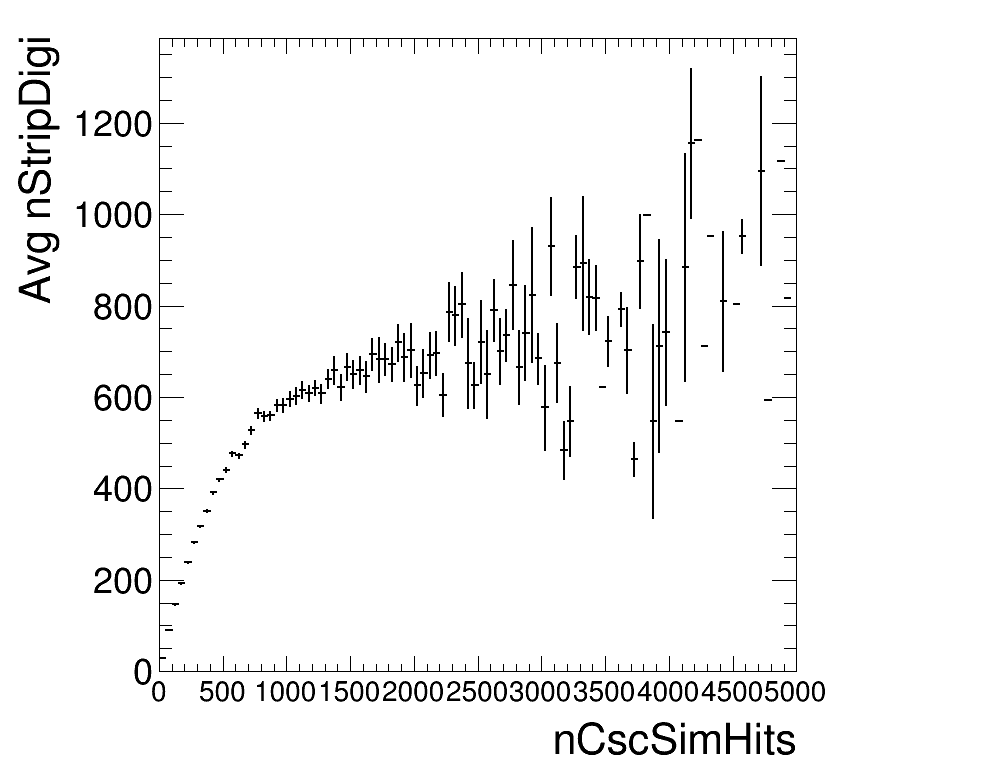

In [75]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'
cond = gLLP_csc[k]
# cond = cscDetLayer_nCscSimHits[k]*0+cond
# cond = cond.flatten()
# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,800,200,0,3000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscRecHits[k][cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((nCscWireDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,800,250,0,3000])
h[k] = create_TH2D(np.column_stack((nCscSimHits[k][cond >= 1],nCscStripDigis[k][cond >= 1])), axis_title = ['nCscSimHits','nStripDigis','Events'], binning=[100,0,5000,200,0,3000])

# h[k] = create_TH2D(np.column_stack((nCscSimHits[k][cond],nCscRecHits[k][cond])), axis_title = ['nCscSimHits','nCscRecHits','Events'], binning=[150,0,2000,150,0,2000])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond==0 ], cscDetLayer_nCscRecHits[k].flatten()[cond ==0 ])), axis_title = ['nCscSimHits','nCscRecHits','Events'], binning=[150,0,1000,150,0,600])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nWireDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscWireDigis','Events'], binning=[150,0,1000,100,0,100])
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscSimHits[k].flatten()[cond >= 1 ], cscDetLayer_nStripDigis[k].flatten()[cond >= 1 ])), axis_title = ['nCscSimHits','nCscStripDigis','Events'], binning=[150,0,1000,100,0,100])



# h[k] = create_TH2D(np.column_stack((nCscRecHits[k][cond],nCscSimHits[k][cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,2000,150,0,2000])



# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])
h[k] = h[k].ProfileX()


# r = h[k].Fit('pol1', 'LRSQ+', '', 100,400)
# print(r.Get())
# print(r.Prob())
# h[k].GetFunction("pol1").SetLineColor(std_color_list[2])
# h[k].GetFunction("pol1").SetLineWidth(2)

h[k].GetXaxis().SetLabelSize(0.04)
h[k].GetYaxis().SetTitle('Avg nStripDigi')




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# 2D plots per layer

In [ ]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'bbbb10m'


cond = gLLP_csc[k]
cond = cscDetLayer_nCscRecHits[k]*0+cond
cond = cond.flatten()
cond = (cond == 1)
# print(len(cond),np.count_nonzero(cond))
# print(len(cscDetLayer_nWireDigis[k].flatten()))
# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscRecHits','Events'], binning=[100,0,100,100,0,500])

# h[k] = create_TH2D(np.column_stack((cscDetLayer_nStripDigis[k].flatten()[cond],cscDetLayer_nCscRecHits[k].flatten()[cond])), axis_title = ['nStripDigis','nCscRecHits','Events'], binning=[50,0,100,50,0,100])


# h[k] = create_TH2D(np.column_stack((cscDetLayer_nWireDigis[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nWireDigis','nCscSimHits','Events'], binning=[100,0,100,250,0,1000])
# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscSimHits[k][cond])), axis_title = ['nStripDigis','nCscSimHits','Events'], binning=[100,0,5000,200,0,3000])

h[k] = create_TH2D(np.column_stack((cscDetLayer_nCscRecHits[k].flatten()[cond],cscDetLayer_nCscSimHits[k].flatten()[cond])), axis_title = ['nCscRecHits','nCscSimHits','Events'], binning=[150,0,200,150,0,800])

print(np.unique(cscDetLayer_nStripDigis[k].flatten()[cond]))
print(np.unique(cscDetLayer_nWireDigis[k].flatten()[cond]))


# h[k] = create_TH2D(np.column_stack((nCscStripDigis[k][cond],nCscWireDigis[k][cond])), axis_title = ['nStripDigis','nWireDigis','Events'], binning=[150,0,5000,150,0,800])

h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)

# SimHit distribution per Layer

20
21
15
19
0
0
[139.24751 137.23349 137.27115 138.99098 138.90771 137.15454 142.48595
 143.86221 149.5309  146.94652 147.00357 148.71863 147.03104 146.97783
 146.92065 133.37749 140.882   141.11513 134.65558 134.87656]
[-530.8045  -531.1113  -530.9534  -528.7419  -528.76105 -526.53644
 -548.13464 -545.5549  -556.1927  -558.4537  -558.67346 -568.353
 -559.07477 -557.6948  -557.789   -522.0904  -546.69196 -546.5215
 -518.37134 -518.3311 ]
[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
20.0 20 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 3.57 s, sys: 2.68 s, total: 6.25 s
Wall time: 6.23 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


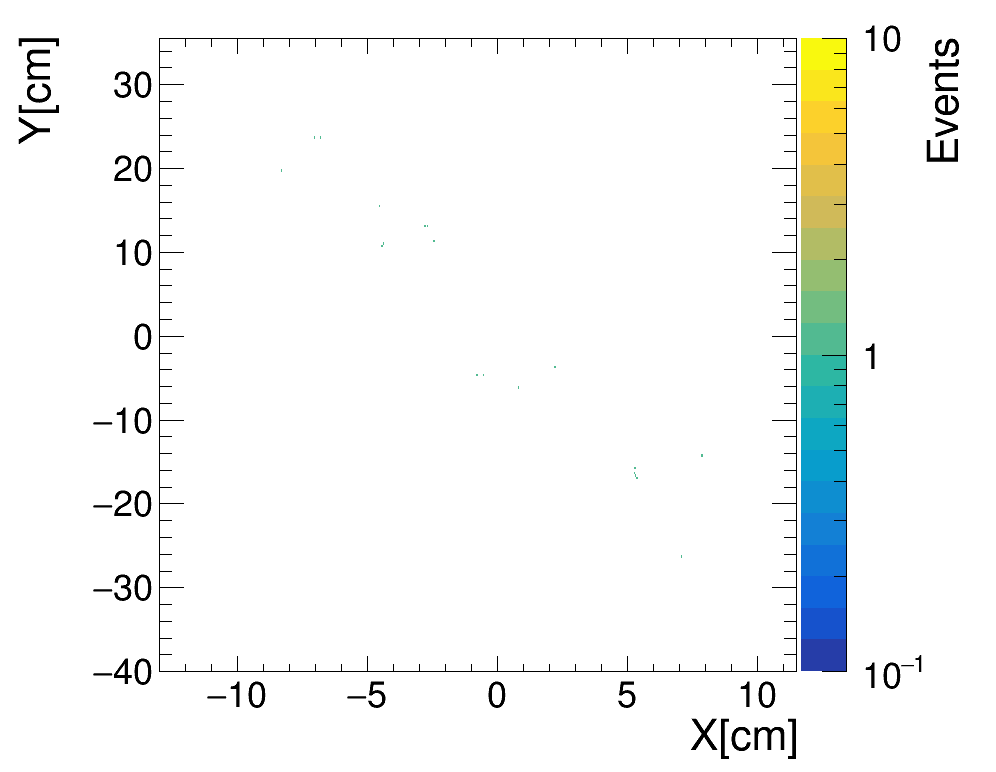

In [58]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

ev = 88785
detid = 604058214
ev = 134356  
detid = 604058858
#   22 12 403 647 1

#   26 20 177 125 1
#   17 0 64 70 1

ev_cond = eventNum[k] == ev
cond = cscSimHitsDetId[k][ev_cond] == detid+1
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid+3][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-1][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-2][0]))
print(len(cscSimHitsX[k][ev_cond][cscSimHitsDetId[k][ev_cond] == detid-3][0]))



meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

print(cscSimHitsX[k][ev_cond][cond][0])
print(cscSimHitsY[k][ev_cond][cond][0])
# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 +1
xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.5 -1
ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 30,-30,20,-20

xnbin = (xmax-xmin)/0.05
ynbin = (ymax-ymin)/0.3
bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)

h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

[490, -13.0, 11.5, 251, -40.0, 35.5]
141.65947 -541.9418 -922.9681
[[ 2.6142578 13.337219 ]] [[ 39.060913 405.22748 ]] [[ 47.24768 425.5171 ]]
[-78.8824    -76.30316   -74.19941    -7.184723   -1.6389618   2.8841248
  -4.611862    1.0366974   5.6436768  -1.5316925   4.2421417   8.950912 ]
9.0 9 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
CPU times: user 1.3 s, sys: 1.11 s, total: 2.41 s
Wall time: 2.4 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb10m (Potential memory leak).


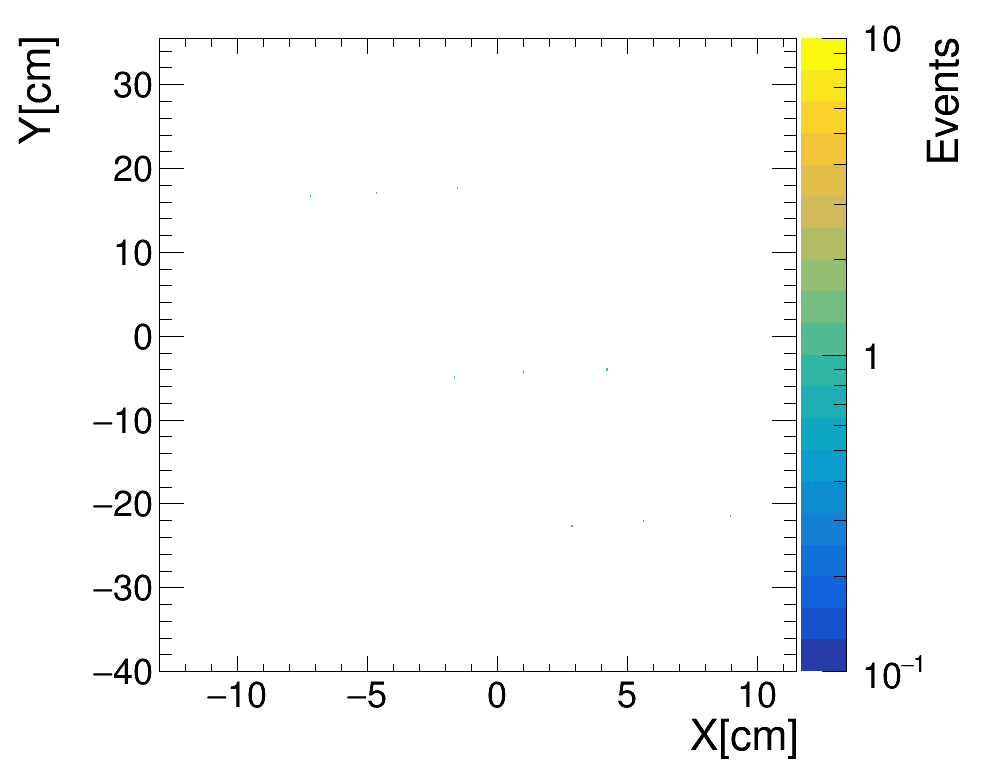

In [59]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

# ev = 17344  
# detid = 604021398

ev_cond = eventNum[k] == ev

cond = cscRecHitsDetId[k][ev_cond] == detid


# meanx = np.mean(cscRecHitsX[k][ev_cond][cond][0])
# meany = np.mean(cscRecHitsY[k][ev_cond][cond][0])
# meanz = np.mean(cscRecHitsZ[k][ev_cond][cond][0])


# print(cscSimHitsParticleType[k][ev_cond][cond][0])
# print(cscSimHitsX[k][ev_cond][cond][0][0]-meanx,cscSimHitsY[k][ev_cond][cond][0][0]-meany)
# xmax = int(np.max(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# xmin = int(np.min(cscRecHitsX[k][ev_cond][cond][0])-meanx) * 1.1
# ymax = int(np.max(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
# ymin = int(np.min(cscRecHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
# xmax,xmin,ymax,ymin = 40,-40,40,-40

# xnbin = (xmax-xmin)
# ynbin = (ymax-ymin)
# bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
print(bins)
print(meanx,meany,meanz)
print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
h[k] = create_TH2D(np.column_stack((cscRecHitsX[k][ev_cond][cond][0]-meanx,cscRecHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
print(cscRecHitsX[k][ev_cond][cond][0]-meanx)
h[k].SetMinimum(.1)
h[k].SetMaximum(10)


h[k].Draw('colz')
c.SetLogz()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()

ll = []
for i in range(1,h[k].GetNbinsX() + 1):
    for j in range(1,h[k].GetNbinsY() + 1):
        temp = h[k].GetBinContent(i,j)
        if temp > 0:
            ll.append(temp)
print(sum(ll),len(ll),ll)
histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])

# Occupancy plot

CPU times: user 470 µs, sys: 0 ns, total: 470 µs
Wall time: 479 µs


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


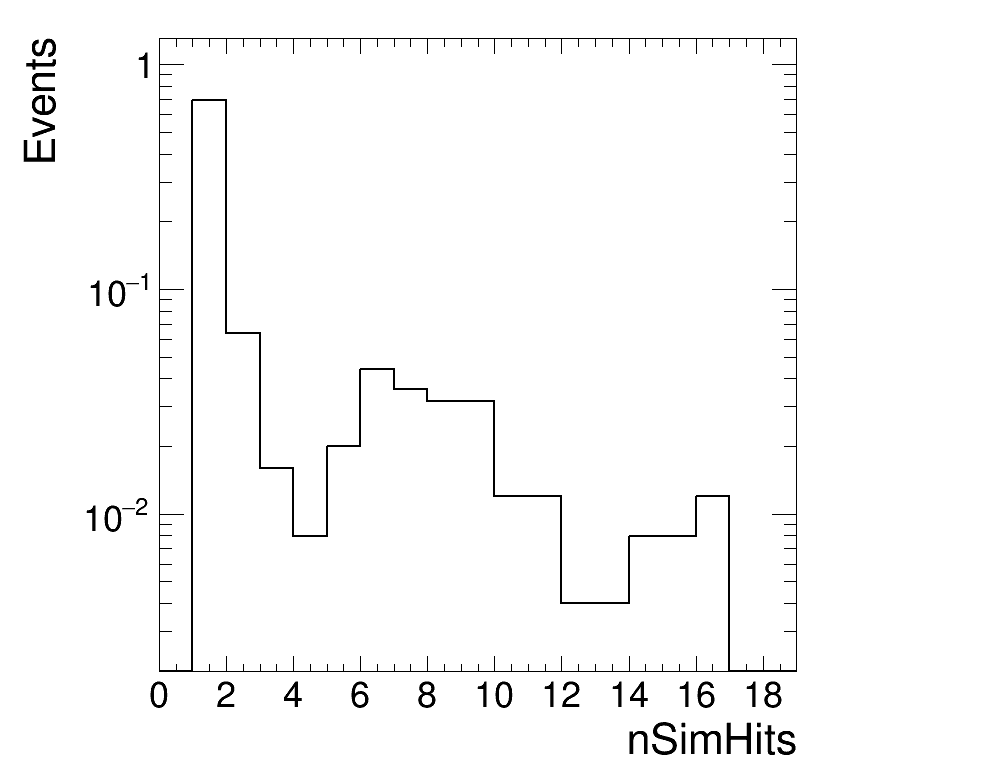

In [53]:
%%time
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)




histo.DrawNormalized('')
c.SetLogy()
c.SetRightMargin(0.2)
# rt.enableJSVis()
c.Draw()



# Occupancy per event

In [ ]:
avg_occupancy = []
max_occupancy = []
for i in range(len(eventNum[k])):
    if len(cscDetLayer_nCscSimHits[k][i]) == 0: continue
    max_index = np.argmax(cscDetLayer_nCscSimHits[k][i])

#     if cscDetLayer_nCscSimHits[k][i][max_index]>750 and gLLP_csc[k][i] == 1:
#         print(ev,cscDetLayer[k][i][max_index],cscDetLayer_nCscSimHits[k][i][max_index], nCscSimHits[k][i], gLLP_csc[k][i])

    cond = cscSimHitsDetId[k][ev_cond] == detid
    meanx = np.mean(cscSimHitsX[k][ev_cond][cond][0])
    meany = np.mean(cscSimHitsY[k][ev_cond][cond][0])
    meanz = np.mean(cscSimHitsZ[k][ev_cond][cond][0])

    xmax = int(np.max(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    xmin = int(np.min(cscSimHitsX[k][ev_cond][cond][0])-meanx) * 1.1
    ymax = int(np.max(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 +1
    ymin = int(np.min(cscSimHitsY[k][ev_cond][cond][0])-meany) * 1.5 -1
    # xmax,xmin,ymax,ymin = 20,-20,20,-20

    xnbin = (xmax-xmin)/0.05
    ynbin = (ymax-ymin)/0.3
    bins = [int(xnbin),xmin,xmax,int(ynbin),ymin,ymax]
#     print(bins)
#     print(meanx,meany,meanz)
#     print(gLLP_decay_vertex_x[k][ev_cond]-meanx, gLLP_decay_vertex_y[k][ev_cond]-meany, gLLP_decay_vertex_z[k][ev_cond]-meanz)
    h[k] = create_TH2D(np.column_stack((cscSimHitsX[k][ev_cond][cond][0]-meanx,cscSimHitsY[k][ev_cond][cond][0]-meany)), axis_title = ['X[cm]','Y[cm]','Events'], binning=bins)
    # print(cscSimHitsY[k][ev_cond][cond][0])


    ll = []
    for i in range(1,h[k].GetNbinsX() + 1):
        for j in range(1,h[k].GetNbinsY() + 1):
            temp = h[k].GetBinContent(i,j)
            if temp > 0:
                ll.append(temp)
    print(sum(ll),ll)
    histo = create_TH1D( ll, axis_title=['nSimHits', 'Events'], name=k, binning=[int(max(ll)),0,int(max(ll))])